In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import datetime
import itertools
import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters  import SimpleExpSmoothing
from statsmodels.tsa.holtwinters  import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("serdargundogdu/municipality-bus-utilization")

print("Path to dataset files:", path)

Path to dataset files: /Users/daniyar_issenov/.cache/kagglehub/datasets/serdargundogdu/municipality-bus-utilization/versions/1


In [4]:
df = pd.read_csv("municipality_bus_utilization.csv", parse_dates=['timestamp'])

In [5]:
df.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [6]:
#df[numeric_columns].describe() 

#убрать большие значения 
#убрать минимальные значнения 
#выявлять границы по признакам 
#векторизация значений TF ATF 
# добавить фиктивные признаки 
# ОБъеденить дата фреймы 


In [7]:
df.shape

(13070, 4)

In [8]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
df["timestamp"].min(), df["timestamp"].max()

(Timestamp('2017-06-04 07:59:42'), Timestamp('2017-08-19 16:30:35'))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [11]:
check_df(df)

##################### Shape #####################
(13070, 4)
##################### Types #####################
timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object
##################### Head #####################
            timestamp  municipality_id  usage  total_capacity
0 2017-06-04 07:59:42                9    454            1332
1 2017-06-04 07:59:42                8    556            2947
2 2017-06-04 07:59:42                4   1090            3893
3 2017-06-04 07:59:42                0    204            2813
4 2017-06-04 07:59:42                7    718            2019
##################### Tail #####################
                timestamp  municipality_id  usage  total_capacity
13065 2017-08-19 16:30:35                2    548             697
13066 2017-08-19 16:30:35                8   1193            2947
13067 2017-08-19 16:30:35                7   1354            2019
13068

In [12]:
df['municipality_id'].value_counts()

9    1307
8    1307
4    1307
0    1307
7    1307
5    1307
2    1307
1    1307
6    1307
3    1307
Name: municipality_id, dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
municipality_id,13070.0,4.500000,2.872391,0.0,2.0,4.5,7.0,9.0
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


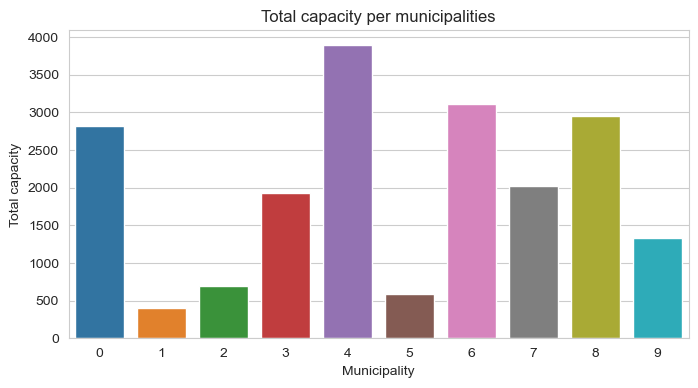

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = df["municipality_id"], y = df["total_capacity"])
plt.xlabel('Municipality')
plt.ylabel('Total capacity')
plt.title('Total capacity per municipalities')
plt.show()

In [15]:
print("-"* 50)
capacities = df[["municipality_id", "total_capacity"]].drop_duplicates().sort_values("municipality_id")
for i in capacities.iterrows():
    print("Total capacity of the municipality {} = {} ~ {}%".format(
        i[1]["municipality_id"], i[1]["total_capacity"], round((i[1]["total_capacity"]*100)/sum(capacities["total_capacity"]), 2)))
   # print(i, type(i))
print("-"*50)
print("total capacity:", sum(capacities["total_capacity"]))

--------------------------------------------------
Total capacity of the municipality 0 = 2813 ~ 14.26%
Total capacity of the municipality 1 = 397 ~ 2.01%
Total capacity of the municipality 2 = 697 ~ 3.53%
Total capacity of the municipality 3 = 1930 ~ 9.78%
Total capacity of the municipality 4 = 3893 ~ 19.73%
Total capacity of the municipality 5 = 587 ~ 2.98%
Total capacity of the municipality 6 = 3113 ~ 15.78%
Total capacity of the municipality 7 = 2019 ~ 10.23%
Total capacity of the municipality 8 = 2947 ~ 14.94%
Total capacity of the municipality 9 = 1332 ~ 6.75%
--------------------------------------------------
total capacity: 19728


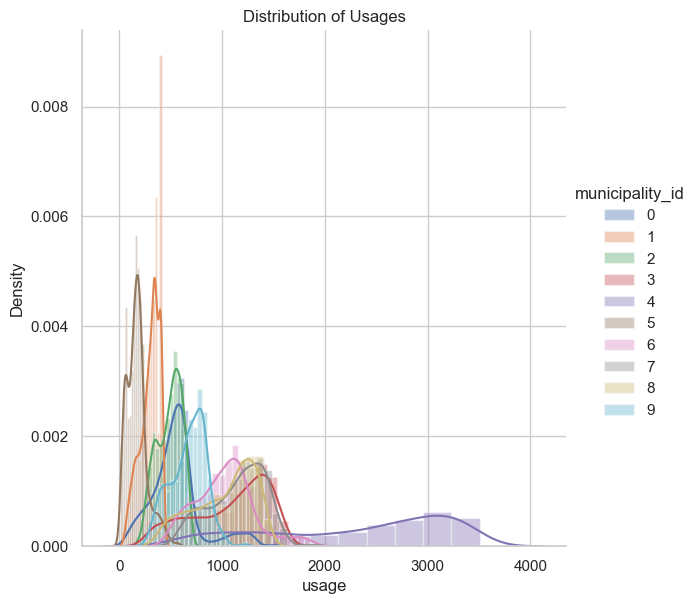

In [16]:
sns.set(style = 'whitegrid')
sns.FacetGrid(df, hue = 'municipality_id', height=6).map(sns.distplot, 'usage').add_legend()
plt.title('Distribution of Usages')
plt.show()

In [17]:
df6 = df[df.municipality_id == 6]
df6.head()

,timestamp,municipality_id,usage,total_capacity
8,2017-06-04 07:59:42,6,597,3113
12,2017-06-04 08:25:42,6,687,3113
28,2017-06-04 08:59:42,6,801,3113
32,2017-06-04 09:32:46,6,941,3113
49,2017-06-04 09:59:48,6,1061,3113


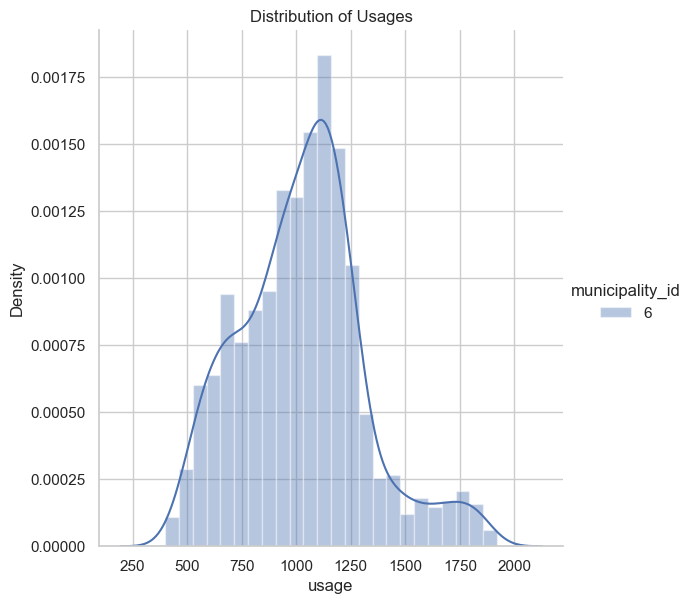

In [18]:
sns.set(style = 'whitegrid')
sns.FacetGrid(df6, hue = 'municipality_id', height=6).map(sns.distplot, 'usage').add_legend()
plt.title('Distribution of Usages')
plt.show()

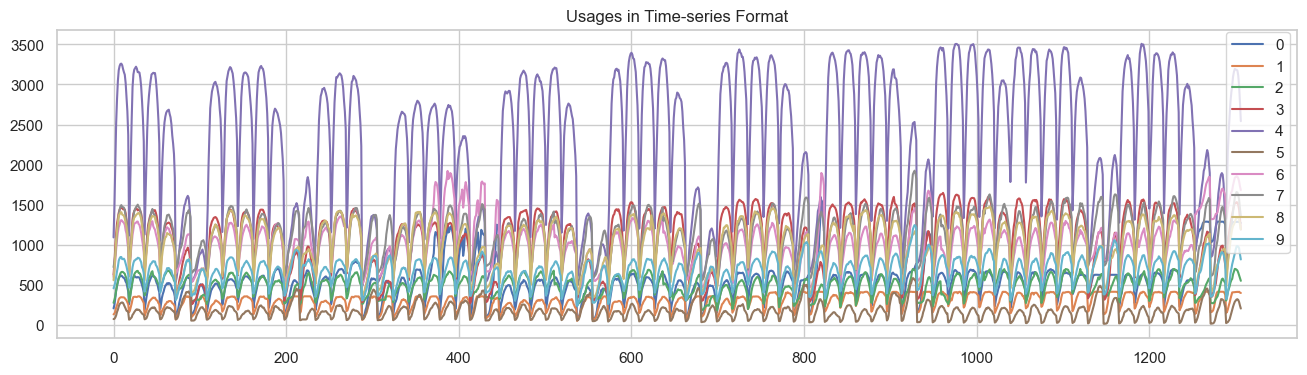

In [19]:
plt.figure(figsize = (16, 4))
for i in range(10):
    plt.plot(df[df['municipality_id'] == i][['usage']].reset_index(drop=True), label=i)
plt.legend(loc='lower right',bbox_to_anchor=(1, 0.25))
plt.title('Usages in Time-series Format')
plt.show()

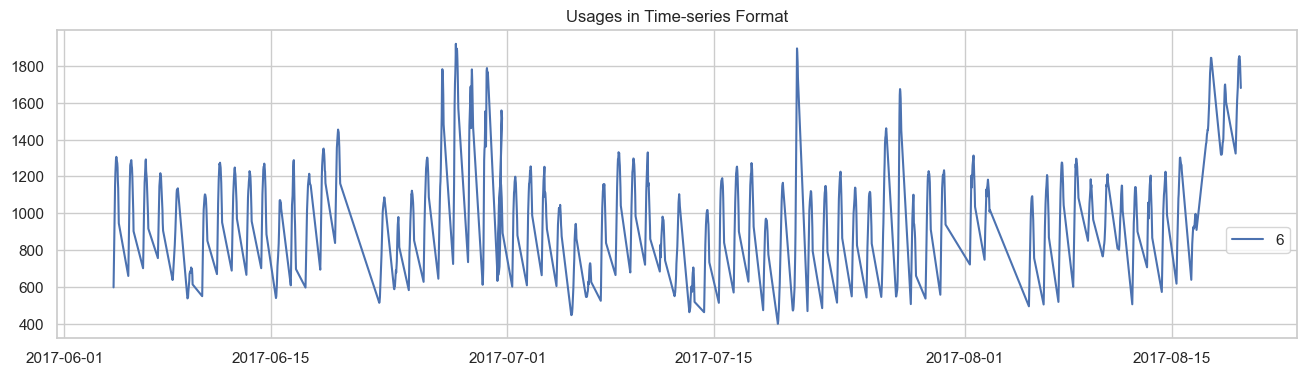

In [20]:
plt.figure(figsize = (16, 4))
plt.plot(df6[["timestamp"]], df6[['usage']].reset_index(drop=True), label=6)
plt.legend(loc='lower right',bbox_to_anchor=(1, 0.25))
plt.title('Usages in Time-series Format')
plt.show()

In [21]:
def create_date_features(df):
    df['hour'] = df.timestamp.dt.hour
    df['month'] = df.timestamp.dt.month
    df['day_of_month'] = df.timestamp.dt.day
    df['day_of_year'] = df.timestamp.dt.dayofyear
    df['week_of_year'] = df.timestamp.dt.weekofyear
    df['day_of_week'] = df.timestamp.dt.dayofweek
    df['year'] = df.timestamp.dt.year
    df["is_wknd"] = df.timestamp.dt.weekday // 4
    df['is_month_start'] = df.timestamp.dt.is_month_start.astype(int)
    df['is_month_end'] = df.timestamp.dt.is_month_end.astype(int)
    return df

In [22]:
df = create_date_features(df)

In [23]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
hour               0
month              0
day_of_month       0
day_of_year        0
week_of_year       0
day_of_week        0
year               0
is_wknd            0
is_month_start     0
is_month_end       0
dtype: int64

In [24]:
df.groupby(["municipality_id","hour"]).agg({"usage": ["count", "max"]})

usage      
                     count   max
municipality_id hour            
0               7       26  1009
                8      145  1041
                9      149  1160
                10     141  1198
                11     146  1278
                12     142  1287
                13     152  1286
                14     145  1349
                15     145  1543
                16     116  1494
1               7       26   230
                8      145   295
                9      149   363
                10     141   407
                11     146   411
                12     142   412
                13     152   412
                14     145   412
                15     145   412
                16     116   412
2               7       26   455
                8      145   521
                9      149   614
                10     141   662
                11     146   696
                12     142   696
                13     152   697
                14     145   696
                15     145   690
                16     116   669
3               7       26   655
                8      145   985
                9      149  1375
                10     141  1511
                11     146  1604
                12     142  1625
                13     152  1631
                14     145  1646
                15     145  1558
                16     116  1436
4               7       26  1775
                8      145  2479
                9      149  3052
                10     141  3393
                11     146  3502
                12     142  3508
                13     152  3505
                14     145  3490
                15     145  3316
                16     116  3018
5               7       26    70
                8      145    89
                9      149   159
                10     141   292
                11     146   379
                12     142   437
                13     152   517
                14     145   582
                15     145   576
                16     116   552
6               7       26  1378
                8      145  1383
                9      149  1553
                10     141  1703
                11     146  1823
                12     142  1920
                13     152  1894
                14     145  1884
                15     145  1895
                16     116  1843
7               7       26   821
                8      145  1073
                9      149  1293
                10     141  1428
                11     146  1541
                12     142  1579
                13     152  1634
                14     145  1876
                15     145  1923
                16     116  1895
8               7       26   637
                8      145  1004
                9      149  1280
                10     141  1437
                11     146  1458
                12     142  1459
                13     152  1476
                14     145  1463
                15     145  1386
                16     116  1253
9               7       26   476
                8      145   561
                9      149   720
                10     141   836
                11     146   897
                12     142   978
                13     152  1053
                14     145  1189
                15     145  1244
                16     116  1235

In [25]:
df.groupby(["week_of_year","municipality_id",]).agg({"usage": ["count", "max"]})

usage      
                             count   max
week_of_year municipality_id            
22           0                  18   614
             1                  18   343
             2                  18   660
             3                  18  1469
             4                  18  3260
             5                  18   278
             6                  18  1306
             7                  18  1493
             8                  18  1406
             9                  18   845
23           0                 126   614
             1                 126   354
             2                 126   676
             3                 126  1455
             4                 126  3222
             5                 126   415
             6                 126  1292
             7                 126  1499
             8                 126  1427
             9                 126   841
24           0                 126   712
             1                 126   354
             2                 126   651
             3                 126  1437
             4                 126  3231
             5                 126   451
             6                 126  1351
             7                 126  1458
             8                 126  1418
             9                 126   936
25           0                  90   793
             1                  90   355
             2                  90   656
             3                  90  1448
             4                  90  3107
             5                  90   439
             6                  90  1454
             7                  90  1458
             8                  90  1409
             9                  90   866
26           0                 141  1261
             1                 141   354
             2                 141   666
             3                 141  1452
             4                 141  3173
             5                 141   426
             6                 141  1920
             7                 141  1507
             8                 141  1403
             9                 141   914
27           0                 126   638
             1                 126   354
             2                 126   687
             3                 126  1530
             4                 126  3396
             5                 126   399
             6                 126  1331
             7                 126  1497
             8                 126  1382
             9                 126   823
28           0                 126   654
             1                 126   354
             2                 126   668
             3                 126  1570
             4                 126  3438
             5                 126   458
             6                 126  1330
             7                 126  1511
             8                 126  1416
             9                 126   898
29           0                 125  1543
             1                 125   411
             2                 125   656
             3                 125  1566
             4                 125  3427
             5                 125   501
             6                 125  1895
             7                 125  1587
             8                 125  1453
             9                 125  1032
30           0                 125  1163
             1                 125   412
             2                 125   696
             3                 125  1646
             4                 125  3507
             5                 125   582
             6                 125  1674
             7                 125  1923
             8                 125  1407
             9                 125  1244
31           0                  72   669
             1                  72   411
             2                  72   696
             3                  72  1595
             4                  72  3461
           

In [26]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2017-06-04 07:59:42,9,454,1332,7,6,4,155,22,6,2017,1,0,0
1,2017-06-04 07:59:42,8,556,2947,7,6,4,155,22,6,2017,1,0,0
2,2017-06-04 07:59:42,4,1090,3893,7,6,4,155,22,6,2017,1,0,0
3,2017-06-04 07:59:42,0,204,2813,7,6,4,155,22,6,2017,1,0,0
4,2017-06-04 07:59:42,7,718,2019,7,6,4,155,22,6,2017,1,0,0


In [27]:
df_resampled = pd.DataFrame()

In [28]:
df["timestamp"] = df["timestamp"].astype(str).apply(lambda x: x[:-6]).astype("datetime64")
df_resampled = df.groupby(["timestamp","municipality_id"]).agg({"usage": "max"}).reset_index()
df_resampled.drop_duplicates(["timestamp","municipality_id"],inplace=True)

In [29]:
df_resampled.head()

,timestamp,municipality_id,usage
0,2017-06-04 07:00:00,0,204
1,2017-06-04 07:00:00,1,129
2,2017-06-04 07:00:00,2,273
3,2017-06-04 07:00:00,3,623
4,2017-06-04 07:00:00,4,1090


In [30]:
dfs={}
for i in range(10):
    dfs[i]= pd.DataFrame(data=df_resampled[df_resampled.municipality_id==i], columns=["timestamp","usage"]).set_index("timestamp")

In [31]:
dfs[6].shape

(674, 1)

In [32]:
type(dfs[6])

pandas.core.frame.DataFrame

In [33]:
trains={}
tests={}
for i in range(10):
    trains[i] = dfs[i][:"2017-08-04 16:00:00"]
    tests[i] = dfs[i]["2017-08-05 07:00:00":]
    print (f"train {i} size:  ", len(trains[i]))
    print (f"test {i} size: ", len(tests[i]))

train 0 size:   532
test 0 size:  142
train 1 size:   532
test 1 size:  142
train 2 size:   532
test 2 size:  142
train 3 size:   532
test 3 size:  142
train 4 size:   532
test 4 size:  142
train 5 size:   532
test 5 size:  142
train 6 size:   532
test 6 size:  142
train 7 size:   532
test 7 size:  142
train 8 size:   532
test 8 size:  142
train 9 size:   532
test 9 size:  142


In [34]:
trains[6].head()

,usage
timestamp,
2017-06-04 07:00:00,597
2017-06-04 08:00:00,801
2017-06-04 09:00:00,1061
2017-06-04 10:00:00,1219
2017-06-04 11:00:00,1297


In [35]:
tests[6].head()

,usage
timestamp,
2017-08-05 08:00:00,571
2017-08-05 09:00:00,755
2017-08-05 10:00:00,903
2017-08-05 11:00:00,1057
2017-08-05 12:00:00,1082


Single Exponential Smoothing

In [36]:
def ses_optimizer(train,test, alphas, step=142):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [37]:
alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(trains[6],tests[6], alphas, step=142)

alpha: 0.01 mae: 239.3938
alpha: 0.11 mae: 228.1232
alpha: 0.21 mae: 228.3075
alpha: 0.31 mae: 228.5778
alpha: 0.41 mae: 229.179
alpha: 0.51 mae: 230.1953
alpha: 0.61 mae: 231.7417
alpha: 0.71 mae: 233.4257
alpha: 0.81 mae: 235.0251
alpha: 0.91 mae: 236.3511
best_alpha: 0.11 best_mae: 228.1232


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
 

In [38]:
ses_model = SimpleExpSmoothing(trains[6]).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(142)

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
tests[6].head()

,usage
timestamp,
2017-08-05 08:00:00,571
2017-08-05 09:00:00,755
2017-08-05 10:00:00,903
2017-08-05 11:00:00,1057
2017-08-05 12:00:00,1082


In [40]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [41]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1083.751736
2017-08-05 09:00:00    1083.751736
2017-08-05 10:00:00    1083.751736
2017-08-05 11:00:00    1083.751736
2017-08-05 12:00:00    1083.751736
Name: usage, dtype: float64

In [42]:
y_pred.index

DatetimeIndex(['2017-08-05 08:00:00', '2017-08-05 09:00:00', '2017-08-05 10:00:00', '2017-08-05 11:00:00', '2017-08-05 12:00:00', '2017-08-05 13:00:00', '2017-08-05 14:00:00', '2017-08-05 15:00:00', '2017-08-05 16:00:00', '2017-08-06 07:00:00',
               ...
               '2017-08-18 16:00:00', '2017-08-19 08:00:00', '2017-08-19 09:00:00', '2017-08-19 10:00:00', '2017-08-19 11:00:00', '2017-08-19 12:00:00', '2017-08-19 13:00:00', '2017-08-19 14:00:00', '2017-08-19 15:00:00', '2017-08-19 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=142, freq=None)

In [43]:
trains[6]["usage"].head()

timestamp
2017-06-04 07:00:00     597
2017-06-04 08:00:00     801
2017-06-04 09:00:00    1061
2017-06-04 10:00:00    1219
2017-06-04 11:00:00    1297
Name: usage, dtype: int64

In [44]:
trains[6]["usage"].index

DatetimeIndex(['2017-06-04 07:00:00', '2017-06-04 08:00:00', '2017-06-04 09:00:00', '2017-06-04 10:00:00', '2017-06-04 11:00:00', '2017-06-04 12:00:00', '2017-06-04 13:00:00', '2017-06-04 14:00:00', '2017-06-04 15:00:00', '2017-06-04 16:00:00',
               ...
               '2017-08-02 07:00:00', '2017-08-02 08:00:00', '2017-08-02 09:00:00', '2017-08-02 10:00:00', '2017-08-02 11:00:00', '2017-08-02 12:00:00', '2017-08-02 13:00:00', '2017-08-02 14:00:00', '2017-08-02 15:00:00', '2017-08-02 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=532, freq=None)

In [45]:
tests[6]["usage"].head()

timestamp
2017-08-05 08:00:00     571
2017-08-05 09:00:00     755
2017-08-05 10:00:00     903
2017-08-05 11:00:00    1057
2017-08-05 12:00:00    1082
Name: usage, dtype: int64

In [46]:
tests[6]["usage"].index

DatetimeIndex(['2017-08-05 08:00:00', '2017-08-05 09:00:00', '2017-08-05 10:00:00', '2017-08-05 11:00:00', '2017-08-05 12:00:00', '2017-08-05 13:00:00', '2017-08-05 14:00:00', '2017-08-05 15:00:00', '2017-08-05 16:00:00', '2017-08-06 07:00:00',
               ...
               '2017-08-18 16:00:00', '2017-08-19 08:00:00', '2017-08-19 09:00:00', '2017-08-19 10:00:00', '2017-08-19 11:00:00', '2017-08-19 12:00:00', '2017-08-19 13:00:00', '2017-08-19 14:00:00', '2017-08-19 15:00:00', '2017-08-19 16:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=142, freq=None)

Double Exponential Smoothing 

In [47]:
def plot_prediction(i,y_pred, label):
    plt.figure(figsize=(16, 4))
    trains[i]["usage"].plot(legend=True, label=f"TRAIN {i}")
    tests[i]["usage"].plot(legend=True, label=f"TEST {i}")
    y_pred["usage"].plot(legend=True, label=f"PREDICTION {i}")
    plt.xlim([datetime.date(2017,6,4), datetime.date(2017,8,20)])
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

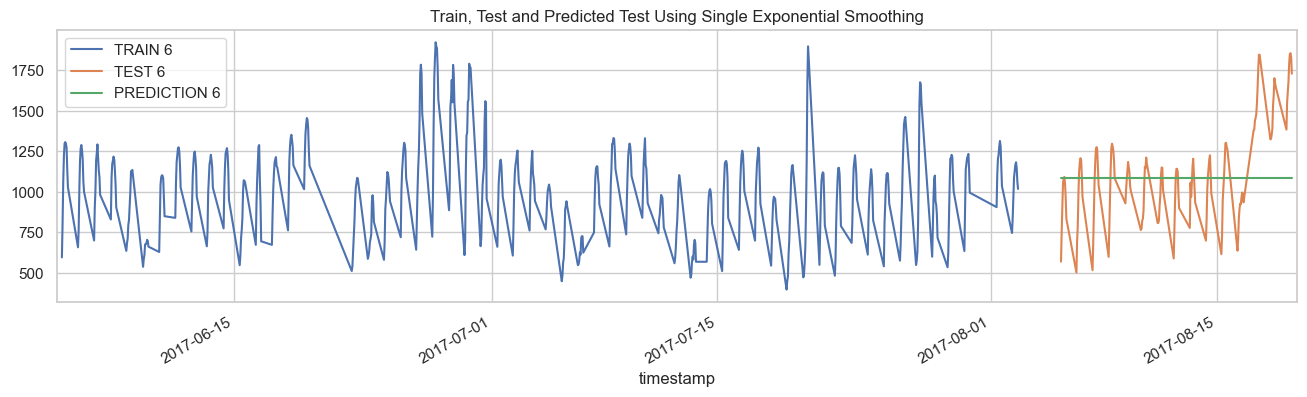

In [48]:
plot_prediction(6, y_pred, "Single Exponential Smoothing")

In [49]:
def des_optimizer(train,test, alphas, betas, step=142):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [50]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(trains[6],tests[6], alphas, betas, step=142)


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

alpha: 0.01 beta: 0.01 mae: 249.3283
alpha: 0.01 beta: 0.11 mae: 219.3942
alpha: 0.01 beta: 0.21 mae: 252.0573
alpha: 0.01 beta: 0.31 mae: 614.176
alpha: 0.01 beta: 0.41 mae: 370.7255
alpha: 0.01 beta: 0.51 mae: 1419.3577
alpha: 0.01 beta: 0.61 mae: 1031.4234
alpha: 0.01 beta: 0.71 mae: 1894.4684
alpha: 0.01 beta: 0.81 mae: 1233.0186
alpha: 0.01 beta: 0.91 mae: 357.9632
alpha: 0.11 beta: 0.01 mae: 220.3818
alpha: 0.11 beta: 0.11 mae: 234.3449
alpha: 0.11 beta: 0.21 mae: 788.8281
alpha: 0.11 beta: 0.31 mae: 1177.9012
alpha: 0.11 beta: 0.41 mae: 369.4635
alpha: 0.11 beta: 0.51 mae: 764.0005
alpha: 0.11 beta: 0.61 mae: 1242.0818
alpha: 0.11 beta: 0.71 mae: 1151.9381
alpha: 0.11 beta: 0.81 mae: 891.304
alpha: 0.11 beta: 0.91 mae: 1233.3061
alpha: 0.21 beta: 0.01 mae: 219.833
alpha: 0.21 beta: 0.11 mae: 310.6273
alpha: 0.21 beta: 0.21 mae: 298.6453
alpha: 0.21 beta: 0.31 mae: 419.7717
alpha: 0.21 beta: 0.41 mae: 1001.1839
alpha: 0.21 beta: 0.51 mae: 1676.2612
alpha: 0.21 beta: 0.61 mae: 244

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

In [51]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(trains[6],tests[6], alphas, betas, step=142)

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

alpha: 0.01 beta: 0.01 mae: 249.3283
alpha: 0.01 beta: 0.11 mae: 219.3942
alpha: 0.01 beta: 0.21 mae: 252.0573
alpha: 0.01 beta: 0.31 mae: 614.176
alpha: 0.01 beta: 0.41 mae: 370.7255
alpha: 0.01 beta: 0.51 mae: 1419.3577
alpha: 0.01 beta: 0.61 mae: 1031.4234
alpha: 0.01 beta: 0.71 mae: 1894.4684
alpha: 0.01 beta: 0.81 mae: 1233.0186
alpha: 0.01 beta: 0.91 mae: 357.9632
alpha: 0.11 beta: 0.01 mae: 220.3818
alpha: 0.11 beta: 0.11 mae: 234.3449
alpha: 0.11 beta: 0.21 mae: 788.8281
alpha: 0.11 beta: 0.31 mae: 1177.9012
alpha: 0.11 beta: 0.41 mae: 369.4635
alpha: 0.11 beta: 0.51 mae: 764.0005
alpha: 0.11 beta: 0.61 mae: 1242.0818
alpha: 0.11 beta: 0.71 mae: 1151.9381
alpha: 0.11 beta: 0.81 mae: 891.304
alpha: 0.11 beta: 0.91 mae: 1233.3061
alpha: 0.21 beta: 0.01 mae: 219.833
alpha: 0.21 beta: 0.11 mae: 310.6273
alpha: 0.21 beta: 0.21 mae: 298.6453
alpha: 0.21 beta: 0.31 mae: 419.7717
alpha: 0.21 beta: 0.41 mae: 1001.1839
alpha: 0.21 beta: 0.51 mae: 1676.2612
alpha: 0.21 beta: 0.61 mae: 244

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

In [52]:
des_model = ExponentialSmoothing(trains[6], trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(142)

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [53]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [54]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1017.475722
2017-08-05 09:00:00    1018.371755
2017-08-05 10:00:00    1019.267789
2017-08-05 11:00:00    1020.163822
2017-08-05 12:00:00    1021.059855
Name: usage, dtype: float64

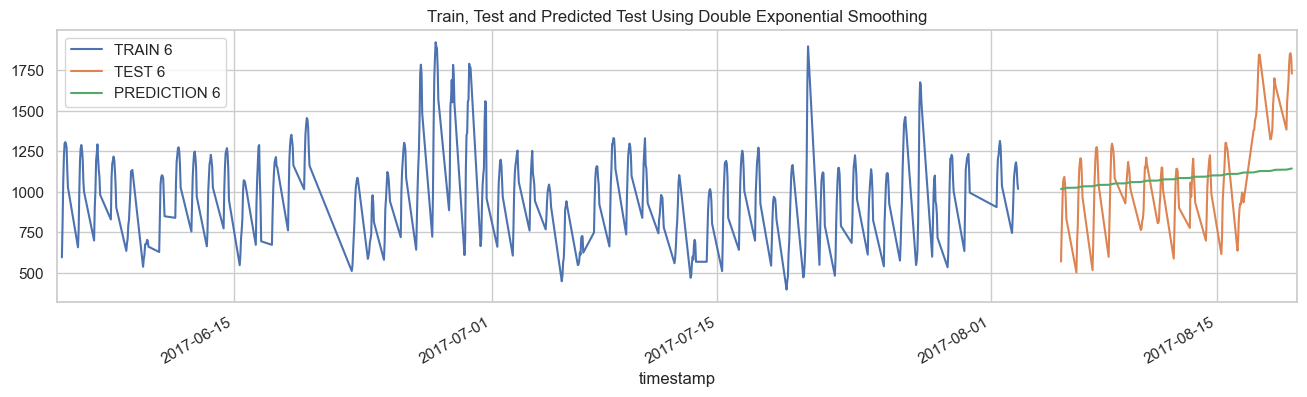

In [55]:
plot_prediction(6, y_pred, "Double Exponential Smoothing")

Tripple Exponential Smoothing

In [56]:
def tes_optimizer(train,test, abg, step=142):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=10).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [57]:
alphas = betas = gammas = np.arange(0.01, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(trains[6], tests[6], abg, step=142)

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

[0.01, 0.01, 0.01, 244.92]
[0.01, 0.01, 0.21, 233.5]
[0.01, 0.01, 0.41, 235.27]
[0.01, 0.01, 0.61, 238.88]
[0.01, 0.01, 0.81, 241.84]
[0.01, 0.21, 0.01, 244.12]
[0.01, 0.21, 0.21, 228.38]
[0.01, 0.21, 0.41, 228.78]
[0.01, 0.21, 0.61, 229.21]
[0.01, 0.21, 0.81, 231.59]
[0.01, 0.41, 0.01, 341.37]
[0.01, 0.41, 0.21, 229.13]
[0.01, 0.41, 0.41, 230.33]
[0.01, 0.41, 0.61, 235.34]
[0.01, 0.41, 0.81, 254.94]
[0.01, 0.61, 0.01, 1033.43]
[0.01, 0.61, 0.21, 343.81]
[0.01, 0.61, 0.41, 233.12]
[0.01, 0.61, 0.61, 255.46]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

[0.01, 0.61, 0.81, 316.94]
[0.01, 0.81, 0.01, 1187.63]
[0.01, 0.81, 0.21, 241.83]
[0.01, 0.81, 0.41, 242.42]
[0.01, 0.81, 0.61, 310.6]
[0.01, 0.81, 0.81, 440.02]
[0.21, 0.01, 0.01, 222.18]
[0.21, 0.01, 0.21, 222.78]
[0.21, 0.01, 0.41, 222.62]
[0.21, 0.01, 0.61, 231.15]
[0.21, 0.01, 0.81, 232.58]
[0.21, 0.21, 0.01, 216.56]
[0.21, 0.21, 0.21, 327.77]
[0.21, 0.21, 0.41, 314.57]
[0.21, 0.21, 0.61, 337.13]
[0.21, 0.21, 0.81, 298.81]
[0.21, 0.41, 0.01, 1516.98]
[0.21, 0.41, 0.21, 1005.03]
[0.21, 0.41, 0.41, 814.79]
[0.21, 0.41, 0.61, 238.07]
[0.21, 0.41, 0.81, 2987.6]
[0.21, 0.61, 0.01, 3284.53]
[0.21, 0.61, 0.21, 2671.76]
[0.21, 0.61, 0.41, 395.22]
[0.21, 0.61, 0.61, 20064.7]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

[0.21, 0.61, 0.81, 6382.92]
[0.21, 0.81, 0.01, 3654.33]
[0.21, 0.81, 0.21, 3384.32]
[0.21, 0.81, 0.41, 605.84]
[0.21, 0.81, 0.61, 5899.48]
[0.21, 0.81, 0.81, 1.0947636820353861e+18]
[0.41, 0.01, 0.01, 221.28]
[0.41, 0.01, 0.21, 226.33]
[0.41, 0.01, 0.41, 220.99]
[0.41, 0.01, 0.61, 228.14]
[0.41, 0.01, 0.81, 242.8]
[0.41, 0.21, 0.01, 370.47]
[0.41, 0.21, 0.21, 298.13]
[0.41, 0.21, 0.41, 1498.8]
[0.41, 0.21, 0.61, 431.75]
[0.41, 0.21, 0.81, 663.85]
[0.41, 0.41, 0.01, 351.7]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa

[0.41, 0.41, 0.21, 628.77]
[0.41, 0.41, 0.41, 3458.45]
[0.41, 0.41, 0.61, 287.69]
[0.41, 0.41, 0.81, 1107.83]
[0.41, 0.61, 0.01, 2059.14]
[0.41, 0.61, 0.21, 7864.29]
[0.41, 0.61, 0.41, 6123.51]
[0.41, 0.61, 0.61, 22406.03]
[0.41, 0.61, 0.81, 2.773504946150684e+22]
[0.41, 0.81, 0.01, 5921.75]
[0.41, 0.81, 0.21, 9732.65]
[0.41, 0.81, 0.41, 5119052628737.96]
[0.41, 0.81, 0.61, 7.165920199746401e+17]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

[0.41, 0.81, 0.81, 1.093044604713291e+22]
[0.61, 0.01, 0.01, 219.12]
[0.61, 0.01, 0.21, 269.1]
[0.61, 0.01, 0.41, 240.98]
[0.61, 0.01, 0.61, 298.73]
[0.61, 0.01, 0.81, 269.67]
[0.61, 0.21, 0.01, 371.35]
[0.61, 0.21, 0.21, 3778.0]
[0.61, 0.21, 0.41, 3372.46]
[0.61, 0.21, 0.61, 1187.97]
[0.61, 0.21, 0.81, 2796.86]
[0.61, 0.41, 0.01, 1893.58]
[0.61, 0.41, 0.21, 10489.11]
[0.61, 0.41, 0.41, 760.96]
[0.61, 0.41, 0.61, 2983.31]
[0.61, 0.41, 0.81, 1778.67]
[0.61, 0.61, 0.01, 4400.41]
[0.61, 0.61, 0.21, 6589.72]
[0.61, 0.61, 0.41, 2065.86]
[0.61, 0.61, 0.61, 640.44]
[0.61, 0.61, 0.81, 5.742841049062273e+21]
[0.61, 0.81, 0.01, 5797.29]
[0.61, 0.81, 0.21, 4113.25]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/

[0.61, 0.81, 0.41, 207697.16]
[0.61, 0.81, 0.61, 904.95]
[0.61, 0.81, 0.81, 2.9207308986414286e+24]
[0.81, 0.01, 0.01, 219.77]
[0.81, 0.01, 0.21, 313.91]
[0.81, 0.01, 0.41, 246.16]
[0.81, 0.01, 0.61, 436.24]
[0.81, 0.01, 0.81, 329.79]
[0.81, 0.21, 0.01, 813.26]
[0.81, 0.21, 0.21, 3668.0]
[0.81, 0.21, 0.41, 1998.58]
[0.81, 0.21, 0.61, 3098.57]
[0.81, 0.21, 0.81, 1982.03]
[0.81, 0.41, 0.01, 2468.81]
[0.81, 0.41, 0.21, 3421.4]
[0.81, 0.41, 0.41, 2029.29]


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

[0.81, 0.41, 0.61, 2306.43]
[0.81, 0.41, 0.81, 1284.52]
[0.81, 0.61, 0.01, 3990.77]
[0.81, 0.61, 0.21, 3117.62]
[0.81, 0.61, 0.41, 3664.08]
[0.81, 0.61, 0.61, 1211.83]
[0.81, 0.61, 0.81, 751072889.91]
[0.81, 0.81, 0.01, 4470.85]
[0.81, 0.81, 0.21, 2390.57]
[0.81, 0.81, 0.41, 647.75]
[0.81, 0.81, 0.61, 4.498829727208338e+17]
[0.81, 0.81, 0.81, 3.227948552138113e+22]
best_alpha: 0.21 best_beta: 0.21 best_gamma: 0.01 best_mae: 216.5592


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [58]:
y_pred.head()

,usage
timestamp,
2017-08-05 08:00:00,1017.475722
2017-08-05 09:00:00,1018.371755
2017-08-05 10:00:00,1019.267789
2017-08-05 11:00:00,1020.163822
2017-08-05 12:00:00,1021.059855


In [59]:
y_pred.reset_index(drop=True,inplace=True)
y_pred=pd.DataFrame(y_pred, columns=["usage"])
y_pred = y_pred.merge(tests[6].reset_index()["timestamp"], left_index=True, right_index=True).set_index("timestamp")

In [60]:
y_pred["usage"].head()

timestamp
2017-08-05 08:00:00    1017.475722
2017-08-05 09:00:00    1018.371755
2017-08-05 10:00:00    1019.267789
2017-08-05 11:00:00    1020.163822
2017-08-05 12:00:00    1021.059855
Name: usage, dtype: float64

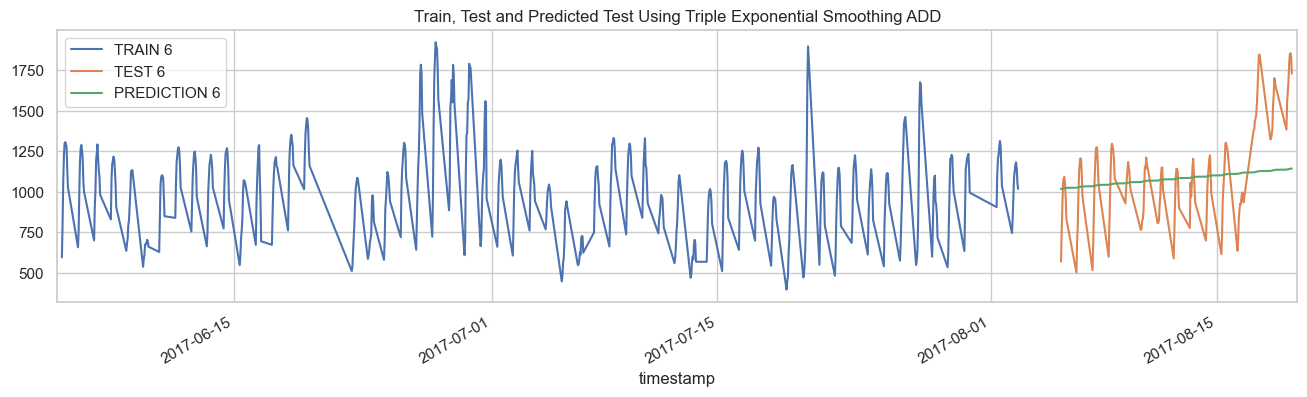

In [61]:
plot_prediction(6, y_pred, "Triple Exponential Smoothing ADD")

SARIMA

In [62]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [63]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}4 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [64]:
best_order, best_seasonal_order = sarima_optimizer_aic(trains[6], pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:8924.330789456793


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:8531.326195945978
SARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:7826.451959971306
SARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:7494.23537675294
SARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:7876.231282168118


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

SARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:160.28554321246457
SARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:7487.589772193282
SARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:7447.954334703003
SARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:8292.580837330632
SARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:7924.1587303382275
SARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:7380.974211001807
SARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:7137.445517820715


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:7435.091761889719


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:127.89033887740072
SARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:7217.476485250633
SARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:7136.500721460513
SARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:7096.075091720344
SARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:7067.023584018985
SARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AIC:7519.819893144597
SARIMA(0, 1, 0)x(0, 1, 1, 4)4 - AIC:7066.112228554659
SARIMA(0, 1, 0)x(1, 0, 0, 4)4 - AIC:7068.9503104258465
SARIMA(0, 1, 0)x(1, 0, 1, 4)4 - AIC:7060.033193831095
SARIMA(0, 1, 0)x(1, 1, 0, 4)4 - AIC:7276.684151910636


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(0, 1, 0)x(1, 1, 1, 4)4 - AIC:7039.696072302264
SARIMA(0, 1, 1)x(0, 0, 0, 4)4 - AIC:7074.449044069258
SARIMA(0, 1, 1)x(0, 0, 1, 4)4 - AIC:7060.198077720905
SARIMA(0, 1, 1)x(0, 1, 0, 4)4 - AIC:7452.147679715947


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(0, 1, 1)x(0, 1, 1, 4)4 - AIC:7044.339998219602
SARIMA(0, 1, 1)x(1, 0, 0, 4)4 - AIC:7062.2343530576
SARIMA(0, 1, 1)x(1, 0, 1, 4)4 - AIC:7051.56918077023


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(0, 1, 1)x(1, 1, 0, 4)4 - AIC:7271.63746693535
SARIMA(0, 1, 1)x(1, 1, 1, 4)4 - AIC:7032.676096412285
SARIMA(1, 0, 0)x(0, 0, 0, 4)4 - AIC:7110.062724833814


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 0)x(0, 0, 1, 4)4 - AIC:7083.180542273559
SARIMA(1, 0, 0)x(0, 1, 0, 4)4 - AIC:7453.8840984589815
SARIMA(1, 0, 0)x(0, 1, 1, 4)4 - AIC:7016.887083131099
SARIMA(1, 0, 0)x(1, 0, 0, 4)4 - AIC:7084.609782132824


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 0)x(1, 0, 1, 4)4 - AIC:7077.269930354634
SARIMA(1, 0, 0)x(1, 1, 0, 4)4 - AIC:7194.577404429232


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 0)x(1, 1, 1, 4)4 - AIC:6997.234677353956
SARIMA(1, 0, 1)x(0, 0, 0, 4)4 - AIC:7086.6399658973805
SARIMA(1, 0, 1)x(0, 0, 1, 4)4 - AIC:7075.100694856224
SARIMA(1, 0, 1)x(0, 1, 0, 4)4 - AIC:7340.858814738722


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 1)x(0, 1, 1, 4)4 - AIC:6969.29682354296
SARIMA(1, 0, 1)x(1, 0, 0, 4)4 - AIC:7076.620424576886


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 1)x(1, 0, 1, 4)4 - AIC:7068.157208097985
SARIMA(1, 0, 1)x(1, 1, 0, 4)4 - AIC:7157.487242183986


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 0, 1)x(1, 1, 1, 4)4 - AIC:6966.779038608676
SARIMA(1, 1, 0)x(0, 0, 0, 4)4 - AIC:7077.5099619820485
SARIMA(1, 1, 0)x(0, 0, 1, 4)4 - AIC:7062.698261102034
SARIMA(1, 1, 0)x(0, 1, 0, 4)4 - AIC:7451.144630731448
SARIMA(1, 1, 0)x(0, 1, 1, 4)4 - AIC:7047.365514543224
SARIMA(1, 1, 0)x(1, 0, 0, 4)4 - AIC:7064.752373952722


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 1, 0)x(1, 0, 1, 4)4 - AIC:7053.817516017611
SARIMA(1, 1, 0)x(1, 1, 0, 4)4 - AIC:7273.343186223378
SARIMA(1, 1, 0)x(1, 1, 1, 4)4 - AIC:7035.227395630339


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 1, 1)x(0, 0, 0, 4)4 - AIC:7076.443557836788
SARIMA(1, 1, 1)x(0, 0, 1, 4)4 - AIC:7061.529683125254
SARIMA(1, 1, 1)x(0, 1, 0, 4)4 - AIC:7451.2380537372555


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 1, 1)x(0, 1, 1, 4)4 - AIC:7046.337249748218
SARIMA(1, 1, 1)x(1, 0, 0, 4)4 - AIC:7063.519575106318


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 1, 1)x(1, 0, 1, 4)4 - AIC:7053.315623814856
SARIMA(1, 1, 1)x(1, 1, 0, 4)4 - AIC:7229.913130219156


/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency in

SARIMA(1, 1, 1)x(1, 1, 1, 4)4 - AIC:6997.186168772108
SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:127.89033887740072


In [65]:
model = SARIMAX(trains[6], order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=142)

y_pred = y_pred_test.predicted_mean
mean_absolute_error(tests[6], y_pred)

/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniyar_issenov/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

100001.18633663781

In [66]:
#Random NOISE 
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [67]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2017-06-04 07:00:00,9,454,1332,7,6,4,155,22,6,2017,1,0,0
1,2017-06-04 07:00:00,8,556,2947,7,6,4,155,22,6,2017,1,0,0
2,2017-06-04 07:00:00,4,1090,3893,7,6,4,155,22,6,2017,1,0,0
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0
4,2017-06-04 07:00:00,7,718,2019,7,6,4,155,22,6,2017,1,0,0


In [68]:
df.sort_values(by=["municipality_id", "total_capacity","timestamp"], axis=0, inplace=True)

In [69]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0
18,2017-06-04 08:00:00,0,247,2813,8,6,4,155,22,6,2017,1,0,0
29,2017-06-04 08:00:00,0,332,2813,8,6,4,155,22,6,2017,1,0,0
34,2017-06-04 09:00:00,0,429,2813,9,6,4,155,22,6,2017,1,0,0
47,2017-06-04 09:00:00,0,485,2813,9,6,4,155,22,6,2017,1,0,0


In [70]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "lag1": df["usage"].shift(1).values[0:10],
              "lag2": df["usage"].shift(2).values[0:10],
              "lag3": df["usage"].shift(3).values[0:10],
              "lag4": df["usage"].shift(4).values[0:10]})


,usage,lag1,lag2,lag3,lag4
0,204,NaN,NaN,NaN,NaN
1,247,204.0,NaN,NaN,NaN
2,332,247.0,204.0,NaN,NaN
3,429,332.0,247.0,204.0,NaN
4,485,429.0,332.0,247.0,204.0
5,534,485.0,429.0,332.0,247.0
6,583,534.0,485.0,429.0,332.0
7,597,583.0,534.0,485.0,429.0
8,614,597.0,583.0,534.0,485.0
9,613,614.0,597.0,583.0,534.0


In [71]:
df.groupby(["municipality_id","total_capacity"])["usage"].head()

3      204
18     247
29     332
34     429
47     485
7      129
19     138
24     164
36     213
46     245
6      273
10     311
23     355
37     423
41     494
9      623
17     770
22     967
39    1130
45    1263
2     1090
14    1476
26    2016
33    2511
43    2811
5       70
16      73
20      89
35     116
40     159
8      597
12     687
28     801
32     941
49    1061
4      718
13     789
27     873
38    1013
44    1151
1      556
15     674
25     857
30    1045
42    1172
0      454
11     487
21     527
31     599
48     666
Name: usage, dtype: int64

In [72]:
df.groupby(["municipality_id","total_capacity"])["usage"].transform(lambda x: x.shift(1))

3           NaN
18        204.0
29        247.0
34        332.0
47        429.0
55        485.0
65        534.0
71        583.0
88        597.0
95        614.0
105       613.0
115       605.0
126       590.0
136       585.0
140       569.0
152       538.0
160       520.0
172       470.0
189       415.0
198       255.0
205       335.0
213       428.0
228       487.0
238       556.0
243       595.0
254       612.0
266       602.0
274       591.0
285       589.0
291       595.0
302       592.0
315       588.0
326       556.0
331       530.0
344       491.0
354       454.0
360       399.0
373       183.0
387       258.0
395       333.0
406       398.0
414       470.0
423       521.0
433       549.0
441       578.0
453       601.0
460       609.0
474       614.0
481       601.0
499       590.0
509       550.0
516       518.0
525       499.0
539       443.0
548       406.0
556       198.0
563       259.0
578       335.0
581       381.0
593       413.0
607       456.0
612       486.0
621     

In [73]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['usage_lag_' + str(lag)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [74]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [75]:
check_df(df)

##################### Shape #####################
(13070, 24)
##################### Types #####################
timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
hour                        int64
month                       int64
day_of_month                int64
day_of_year                 int64
week_of_year                int64
day_of_week                 int64
year                        int64
is_wknd                     int64
is_month_start              int64
is_month_end                int64
usage_lag_91              float64
usage_lag_98              float64
usage_lag_105             float64
usage_lag_112             float64
usage_lag_119             float64
usage_lag_126             float64
usage_lag_182             float64
usage_lag_364             float64
usage_lag_546             float64
usage_lag_728             float64
dtype: object
##################### Head #####################
         

ROLLING MEAN FEATURES 

In [76]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].rolling(window=2).mean().values[0:10],
              "roll3": df["usage"].rolling(window=3).mean().values[0:10],
              "roll5": df["usage"].rolling(window=5).mean().values[0:10]})

pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["usage"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["usage"].shift(1).rolling(window=5).mean().values[0:10]})

,usage,roll2,roll3,roll5
0,204,NaN,NaN,NaN
1,247,NaN,NaN,NaN
2,332,225.5,NaN,NaN
3,429,289.5,261.000000,NaN
4,485,380.5,336.000000,NaN
5,534,457.0,415.333333,339.4
6,583,509.5,482.666667,405.4
7,597,558.5,534.000000,472.6
8,614,590.0,571.333333,525.6
9,613,605.5,598.000000,562.6


In [77]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['usage_roll_mean_' + str(window)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [78]:
df = roll_mean_features(df, [365, 546])

In [79]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,usage_lag_91,usage_lag_98,usage_lag_105,usage_lag_112,usage_lag_119,usage_lag_126,usage_lag_182,usage_lag_364,usage_lag_546,usage_lag_728,usage_roll_mean_365,usage_roll_mean_546
3,2017-06-04 07:00:00,0,204,2813,7,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2017-06-04 08:00:00,0,247,2813,8,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2017-06-04 08:00:00,0,332,2813,8,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,2017-06-04 09:00:00,0,429,2813,9,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2017-06-04 09:00:00,0,485,2813,9,6,4,155,22,6,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Exponentially Weighted MEan Features 

In [80]:
pd.DataFrame({"usage": df["usage"].values[0:10],
              "roll2": df["usage"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["usage"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["usage"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["usage"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["usage"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,usage,roll2,ewm099,ewm095,ewm07,ewm02
0,204,NaN,NaN,NaN,NaN,NaN
1,247,NaN,204.000000,204.000000,204.000000,204.000000
2,332,225.5,246.574257,244.952381,237.076923,226.631579
3,429,289.5,331.145827,327.657957,305.366906,265.512915
4,485,380.5,428.021459,423.933500,392.616796,313.052050
5,534,457.0,484.430215,481.946693,457.442565,355.040756
6,583,509.5,533.504302,531.397335,511.071865,393.234291
7,597,558.5,582.505043,580.419867,561.432574,429.608564
8,614,590.0,596.855050,596.170993,586.331406,458.999573
9,613,605.5,613.828551,613.108550,605.699803,484.302481


In [81]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['usage_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [82]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
check_df(df)

##################### Shape #####################
(13070, 71)
##################### Types #####################
timestamp                      datetime64[ns]
municipality_id                         int64
usage                                   int64
total_capacity                          int64
hour                                    int64
month                                   int64
day_of_month                            int64
day_of_year                             int64
week_of_year                            int64
day_of_week                             int64
year                                    int64
is_wknd                                 int64
is_month_start                          int64
is_month_end                            int64
usage_lag_91                          float64
usage_lag_98                          float64
usage_lag_105                         float64
usage_lag_112                         float64
usage_lag_119                         float64
usage_lag_126 

One-Hot Encoding 

In [83]:
df = pd.get_dummies(df, columns=['municipality_id', 'total_capacity', 'day_of_week', 'hour'])


check_df(df)

##################### Shape #####################
(13070, 104)
##################### Types #####################
timestamp                      datetime64[ns]
usage                                   int64
month                                   int64
day_of_month                            int64
day_of_year                             int64
week_of_year                            int64
year                                    int64
is_wknd                                 int64
is_month_start                          int64
is_month_end                            int64
usage_lag_91                          float64
usage_lag_98                          float64
usage_lag_105                         float64
usage_lag_112                         float64
usage_lag_119                         float64
usage_lag_126                         float64
usage_lag_182                         float64
usage_lag_364                         float64
usage_lag_546                         float64
usage_lag_728

timestamp                         0
usage                             0
month                             0
day_of_month                      0
day_of_year                       0
week_of_year                      0
year                              0
is_wknd                           0
is_month_start                    0
is_month_end                      0
usage_lag_91                    910
usage_lag_98                    980
usage_lag_105                  1050
usage_lag_112                  1120
usage_lag_119                  1190
usage_lag_126                  1260
usage_lag_182                  1820
usage_lag_364                  3640
usage_lag_546                  5460
usage_lag_728                  7280
usage_roll_mean_365             100
usage_roll_mean_546             100
usage_ewm_alpha_095_lag_91      910
usage_ewm_alpha_095_lag_98      980
usage_ewm_alpha_095_lag_105    1050
usage_ewm_alpha_095_lag_112    1120
usage_ewm_alpha_095_lag_180    1800
usage_ewm_alpha_095_lag_270 

In [84]:
df.head()

,timestamp,usage,month,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,usage_lag_91,usage_lag_98,usage_lag_105,usage_lag_112,usage_lag_119,usage_lag_126,usage_lag_182,usage_lag_364,usage_lag_546,usage_lag_728,usage_roll_mean_365,usage_roll_mean_546,usage_ewm_alpha_095_lag_91,usage_ewm_alpha_095_lag_98,usage_ewm_alpha_095_lag_105,usage_ewm_alpha_095_lag_112,usage_ewm_alpha_095_lag_180,usage_ewm_alpha_095_lag_270,usage_ewm_alpha_095_lag_365,usage_ewm_alpha_095_lag_546,usage_ewm_alpha_095_lag_728,usage_ewm_alpha_09_lag_91,usage_ewm_alpha_09_lag_98,usage_ewm_alpha_09_lag_105,usage_ewm_alpha_09_lag_112,usage_ewm_alpha_09_lag_180,usage_ewm_alpha_09_lag_270,usage_ewm_alpha_09_lag_365,usage_ewm_alpha_09_lag_546,usage_ewm_alpha_09_lag_728,usage_ewm_alpha_08_lag_91,usage_ewm_alpha_08_lag_98,usage_ewm_alpha_08_lag_105,usage_ewm_alpha_08_lag_112,usage_ewm_alpha_08_lag_180,usage_ewm_alpha_08_lag_270,usage_ewm_alpha_08_lag_365,usage_ewm_alpha_08_lag_546,usage_ewm_alpha_08_lag_728,usage_ewm_alpha_07_lag_91,usage_ewm_alpha_07_lag_98,usage_ewm_alpha_07_lag_105,usage_ewm_alpha_07_lag_112,usage_ewm_alpha_07_lag_180,usage_ewm_alpha_07_lag_270,usage_ewm_alpha_07_lag_365,usage_ewm_alpha_07_lag_546,usage_ewm_alpha_07_lag_728,usage_ewm_alpha_05_lag_91,usage_ewm_alpha_05_lag_98,usage_ewm_alpha_05_lag_105,usage_ewm_alpha_05_lag_112,usage_ewm_alpha_05_lag_180,usage_ewm_alpha_05_lag_270,usage_ewm_alpha_05_lag_365,usage_ewm_alpha_05_lag_546,usage_ewm_alpha_05_lag_728,municipality_id_0,municipality_id_1,municipality_id_2,municipality_id_3,municipality_id_4,municipality_id_5,municipality_id_6,municipality_id_7,municipality_id_8,municipality_id_9,total_capacity_397,total_capacity_587,total_capacity_697,total_capacity_1332,total_capacity_1930,total_capacity_2019,total_capacity_2813,total_capacity_2947,total_capacity_3113,total_capacity_3893,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16
3,2017-06-04 07:00:00,204,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
18,2017-06-04 08:00:00,247,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
29,2017-06-04 08:00:00,332,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
34,2017-06-04 09:00:00,429,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
47,2017-06-04 09:00:00,485,6,4,155,22,2017,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [123]:
train = df.loc[(df["timestamp"] <"2017-08-05"),:]
val = df.loc[(df["timestamp"] >="2017-08-05"),:]

In [124]:
cols = [col for col in train.columns if col not in ["timestamp", "usage","year"]]

In [125]:
Y_train = train["usage"]
X_train = train[cols]

In [126]:
Y_val = val['usage']
X_val = val[cols]

In [127]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((10390,), (10390, 101), (2680,), (2680, 101))

In [128]:
#pip install lightgbm

In [129]:
import lightgbm as lgb
lgb_params = {
    'num_leaves': 10,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'max_depth': 5,
    'verbose': 0,
    'num_boost_round': 1000,
    'early_stopping_rounds': 200,
    'nthread': -1
}

In [130]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [131]:
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [132]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [133]:
print(lgb.__version__)

4.5.0


In [ ]:
#import lightgbm as lgb 

In [ ]:
#pip install --upgrade lightgbm

In [ ]:
model = lgb.train(params, train_data, valid_sets=[valid_data])